[I 2025-06-23 13:59:22,392] Trial 33 finished with value: 0.7553540682792663 and parameters: {'window_size': 48, 'learning_rate': 6.306529164898755e-05, 'n_layers': 3, 'n_channels_l0': 40, 'n_channels_l1': 30, 'n_channels_l2': 44, 'kernel_size': 2, 'dropout': 0.1478850045357742, 'batch_size': 16}. Best is trial 22 with value: 0.7550004601478577.
[I 2025-06-23 13:59:24,387] Trial 34 pruned. 
[I 2025-06-23 13:59:26,191] Trial 35 pruned. 
[I 2025-06-23 13:59:27,808] Trial 36 pruned. 
[I 2025-06-23 13:59:29,801] Trial 37 pruned. 
[I 2025-06-23 13:59:31,151] Trial 38 pruned. 
[I 2025-06-23 13:59:32,507] Trial 39 pruned. 
[I 2025-06-23 13:59:34,363] Trial 40 pruned. 
[I 2025-06-23 13:59:35,941] Trial 41 pruned. 
[I 2025-06-23 13:59:52,587] Trial 42 finished with value: 0.7437984446684519 and parameters: {'window_size': 47, 'learning_rate': 3.2170744359178596e-05, 'n_layers': 3, 'n_channels_l0': 38, 'n_channels_l1': 36, 'n_channels_l2': 55, 'kernel_size': 2, 'dropout': 0.11514366801401965, 'b


Mejores hiperparámetros encontrados:
window_size: 47
learning_rate: 3.809364979874407e-05
n_layers: 2
n_channels_l0: 61
n_channels_l1: 23
kernel_size: 2
dropout: 0.15314695726351546
batch_size: 16

Mejor MSE en validación: 0.5887
Entrenando modelo final con ventana de tamaño 47
Entrenando modelo final...
Época 10/100 - Train Loss: 10.4332, Val Loss: 2.4342
Época 20/100 - Train Loss: 9.5887, Val Loss: 1.9612
Época 30/100 - Train Loss: 9.1039, Val Loss: 1.7296
Época 40/100 - Train Loss: 8.7485, Val Loss: 1.5257
Época 50/100 - Train Loss: 8.4348, Val Loss: 1.3624
Época 60/100 - Train Loss: 8.1497, Val Loss: 1.1725
Época 70/100 - Train Loss: 7.7955, Val Loss: 1.1207
Época 80/100 - Train Loss: 7.4854, Val Loss: 0.8638
Época 90/100 - Train Loss: 7.0781, Val Loss: 0.9103
Época 100/100 - Train Loss: 6.7169, Val Loss: 0.9498


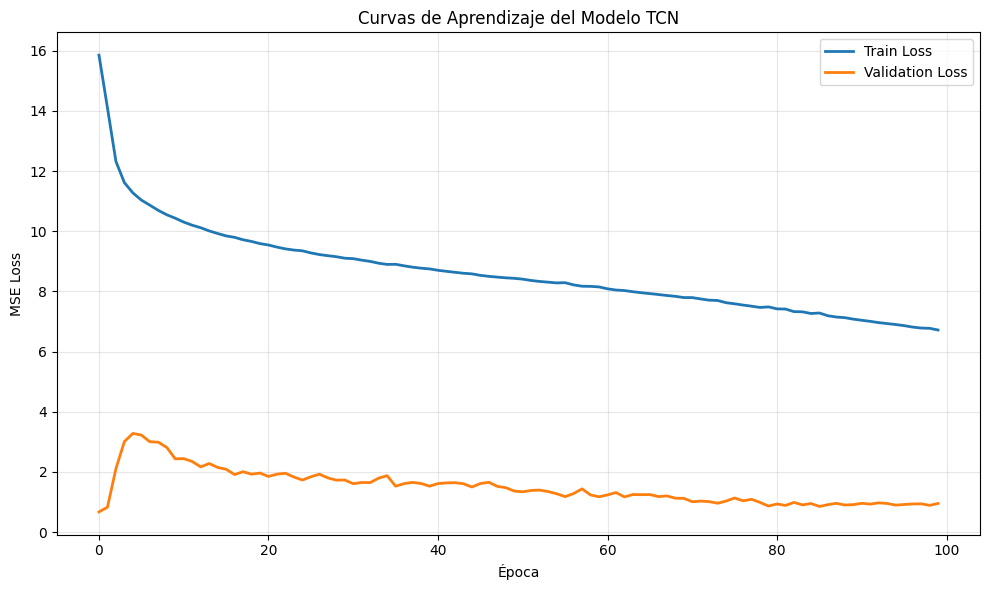

Generando pronósticos para 2022...

Pronósticos generados: 520 registros
   id_bar  anio  semana    dengue
0       4  2022       1  1.237309
1       4  2022       2  1.020435
2       4  2022       3  1.267558
3       4  2022       4  1.289368
4       4  2022       5  1.360940

Archivo 'pronosticos_2022.csv' guardado con 520 pronósticos

Primeras filas del archivo de salida:
          id    dengue
0  4_2022_01  1.237309
1  4_2022_02  1.020435
2  4_2022_03  1.267558
3  4_2022_04  1.289368
4  4_2022_05  1.360940
5  4_2022_06  1.360940
6  4_2022_07  1.360940
7  4_2022_08  1.360940
8  4_2022_09  1.360940
9  4_2022_10  1.360940


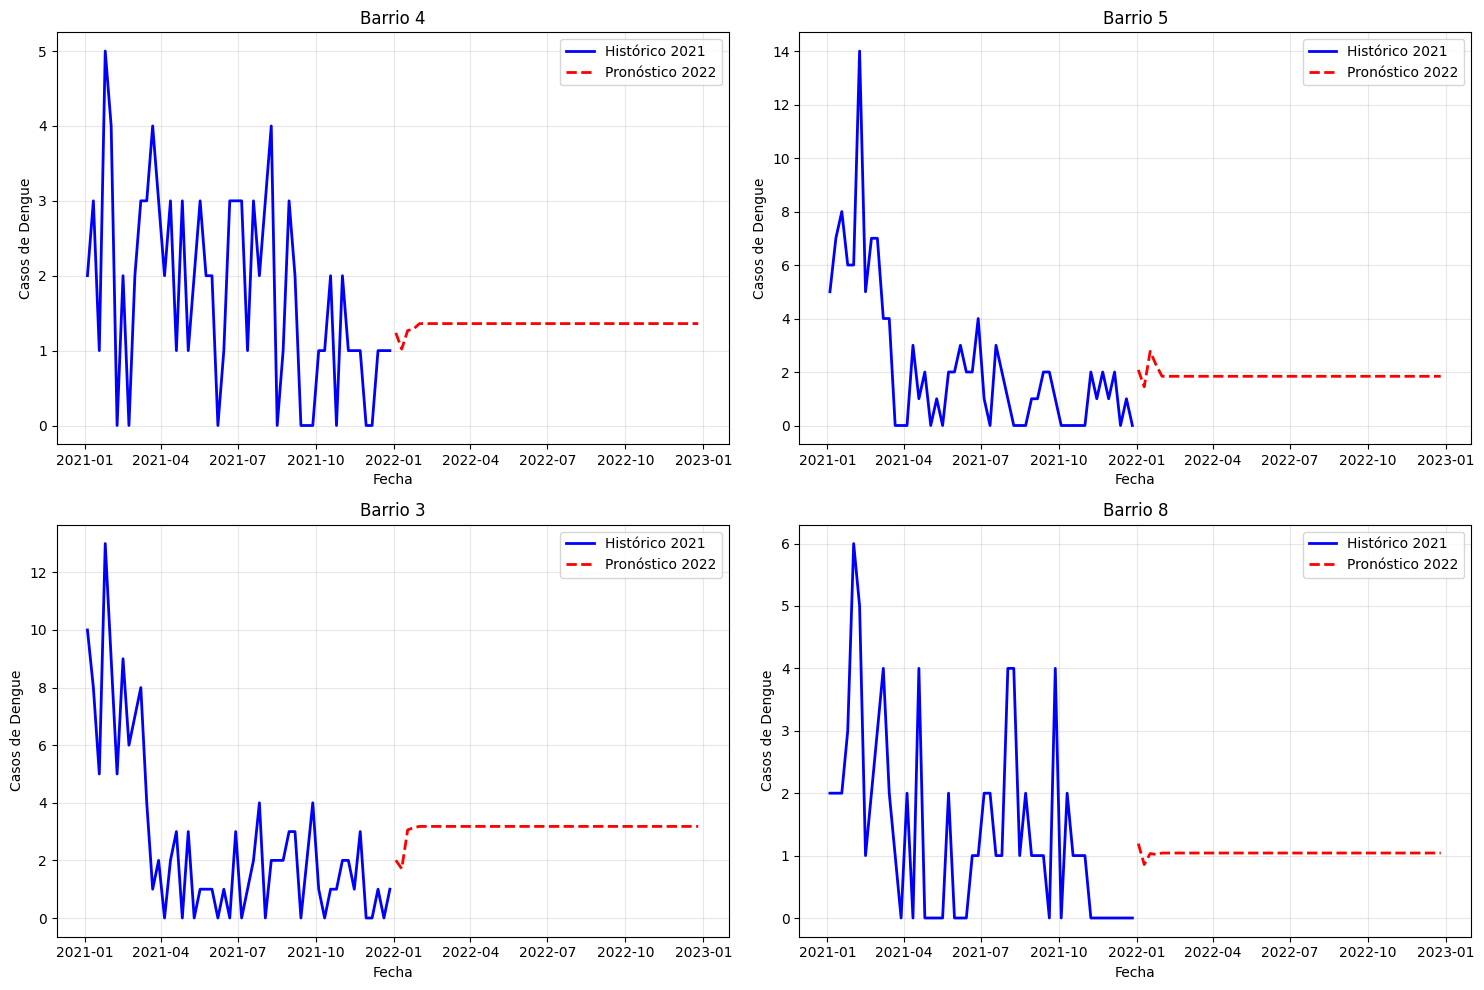


Modelo y configuración guardados exitosamente!
- Modelo PyTorch: tcn_dengue_model.pth
- Información del modelo: model_info.json
- Pronósticos: pronosticos_2022.csv


In [2]:
# %% [markdown]
# # Pronóstico de Casos de Dengue usando Temporal Convolutional Networks (TCN)
# 
# Este notebook implementa una red TCN para pronosticar el número de casos de dengue por barrio,
# utilizando PyTorch y optimización de hiperparámetros con Optuna.

# %% [markdown]
# ## 1. Configuración e Importación de Librerías

# %%
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import optuna
from optuna.trial import TrialState
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os
from typing import Tuple, List, Dict
import json

warnings.filterwarnings('ignore')

# Configurar dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Configurar semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

# %% [markdown]
# ## 2. Carga de Datos

# %%
# Cargar el conjunto de datos
df_train = pd.read_parquet('../../Datos/df_train.parquet')

print(f"Forma del dataset: {df_train.shape}")
print(f"\nPrimeras filas:")
print(df_train.head())
print(f"\nInformación del dataset:")
print(df_train.info())

# %% [markdown]
# ## 3. Ingeniería de Características y Preprocesamiento

# %%
# 3.1 Manejo del Tiempo
# Crear columna de fecha combinando año y semana (asumiendo semanas ISO)
def create_date_from_year_week(year, week):
    """Crea una fecha a partir del año y número de semana ISO."""
    # El 4 de enero siempre está en la semana 1 ISO
    jan4 = datetime(year, 1, 4)
    # Encontrar el lunes de la semana 1
    week_one_monday = jan4 - timedelta(days=jan4.weekday())
    # Calcular la fecha del lunes de la semana deseada
    return week_one_monday + timedelta(weeks=week - 1)

# Aplicar la función para crear la columna de fecha
df_train['fecha'] = df_train.apply(
    lambda row: create_date_from_year_week(int(row['anio']), int(row['semana'])), 
    axis=1
)

# Establecer la fecha como índice
df_train.set_index('fecha', inplace=True)
df_train.sort_index(inplace=True)

print("Dataset con fecha como índice:")
print(df_train.head())

# %%
# 3.2 Identificar variables numéricas y categóricas
categorical_vars = ['id_bar', 'ESTRATO']
numerical_vars = [col for col in df_train.columns 
                 if col not in categorical_vars + ['dengue', 'anio', 'semana']]
target_var = 'dengue'

print(f"Variables categóricas: {categorical_vars}")
print(f"Variables numéricas: {numerical_vars}")
print(f"Variable objetivo: {target_var}")

# Verificar cardinalidad de variables categóricas
for var in categorical_vars:
    print(f"\nCardinalidad de {var}: {df_train[var].nunique()}")

# %%
# 3.3 Preparar escaladores y mapeos para entity embeddings
# Crear mapeos para variables categóricas
cat_mappings = {}
for var in categorical_vars:
    unique_values = df_train[var].unique()
    cat_mappings[var] = {val: idx for idx, val in enumerate(unique_values)}
    # Agregar índice para valores desconocidos
    cat_mappings[var]['<UNK>'] = len(unique_values)

# Dimensiones de embeddings (regla general: min(50, (cardinalidad+1)//2))
embedding_dims = {}
for var in categorical_vars:
    cardinality = len(cat_mappings[var])
    embedding_dims[var] = min(50, (cardinality + 1) // 2)
    print(f"Dimensión de embedding para {var}: {embedding_dims[var]}")

# Crear escalador para variables numéricas
scaler = StandardScaler()
df_train[numerical_vars] = scaler.fit_transform(df_train[numerical_vars])

# %% [markdown]
# ## 4. Creación de Secuencias

# %%
def create_sequences(df, window_size, target_col='dengue'):
    """
    Crea secuencias de datos para alimentar a la TCN.
    
    Args:
        df: DataFrame con los datos
        window_size: Tamaño de la ventana temporal
        target_col: Nombre de la columna objetivo
    
    Returns:
        sequences: Array con las secuencias de entrada
        targets: Array con los valores objetivo
        metadata: Información adicional (id_bar, fecha, etc.)
    """
    sequences = []
    targets = []
    metadata = []
    
    # Agrupar por id_bar para crear secuencias por barrio
    for id_bar, group_df in df.groupby('id_bar'):
        group_df = group_df.sort_index()
        
        # Crear secuencias para este barrio
        for i in range(window_size, len(group_df)):
            # Ventana de entrada
            window_data = group_df.iloc[i-window_size:i]
            
            # Preparar features numéricas
            num_features = window_data[numerical_vars].values
            
            # Preparar features categóricas (solo necesitamos los índices)
            cat_features = []
            for var in categorical_vars:
                cat_indices = [cat_mappings[var].get(val, cat_mappings[var]['<UNK>']) 
                              for val in window_data[var].values]
                cat_features.append(cat_indices)
            
            # Combinar todo
            sequence = {
                'numerical': num_features,
                'categorical': np.array(cat_features).T,  # Transponer para tener (seq_len, n_cats)
                'id_bar': id_bar,
                'estrato': window_data['ESTRATO'].iloc[-1]
            }
            
            sequences.append(sequence)
            targets.append(group_df.iloc[i][target_col])
            metadata.append({
                'id_bar': id_bar,
                'fecha': group_df.index[i],
                'anio': group_df.iloc[i]['anio'],
                'semana': group_df.iloc[i]['semana']
            })
    
    return sequences, np.array(targets), metadata

# %% [markdown]
# ## 5. División de Datos (Train/Validation)

# %%
# Separar datos por año
train_df = df_train[df_train['anio'] < 2021]
val_df = df_train[df_train['anio'] >= 2021]

print(f"Tamaño conjunto entrenamiento: {len(train_df)}")
print(f"Tamaño conjunto validación: {len(val_df)}")
print(f"Años en entrenamiento: {sorted(train_df['anio'].unique())}")
print(f"Años en validación: {sorted(val_df['anio'].unique())}")

# %% [markdown]
# ## 6. Definición del Modelo TCN con PyTorch
# 
# **Nota sobre el padding**: Las convoluciones dilatadas pueden cambiar el tamaño de la secuencia.
# Para mantener las dimensiones consistentes a través de las capas, calculamos el padding apropiado
# y ajustamos las dimensiones en las conexiones residuales cuando sea necesario.

# %%
class TemporalBlock(nn.Module):
    """Bloque temporal básico para TCN."""
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        # Calcular padding para mantener el tamaño
        self.padding = (kernel_size - 1) * dilation // 2
        
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                               stride=stride, padding=self.padding, dilation=dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                               stride=stride, padding=self.padding, dilation=dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        self.net = nn.Sequential(self.conv1, self.relu1, self.dropout1,
                                self.conv2, self.relu2, self.dropout2)
        
        # Residual connection
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        
        # Ajustar dimensiones si es necesario
        if out.shape[2] != res.shape[2]:
            # Recortar o hacer padding para que coincidan las dimensiones
            min_len = min(out.shape[2], res.shape[2])
            out = out[:, :, :min_len]
            res = res[:, :, :min_len]
            
        return self.relu(out + res)


class TCN(nn.Module):
    """Temporal Convolutional Network con entity embeddings."""
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2,
                 embedding_dims=None, cat_mappings=None):
        super(TCN, self).__init__()
        
        # Entity Embeddings para variables categóricas
        self.embeddings = nn.ModuleDict()
        self.embedding_dims = embedding_dims or {}
        self.cat_mappings = cat_mappings or {}
        
        total_embedding_dim = 0
        for var, dim in self.embedding_dims.items():
            vocab_size = len(self.cat_mappings[var])
            self.embeddings[var] = nn.Embedding(vocab_size, dim)
            total_embedding_dim += dim
        
        # Dimensión total de entrada (numéricas + embeddings)
        self.total_input_dim = num_inputs + total_embedding_dim
        
        # Capas TCN
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = self.total_input_dim if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size, 
                                      stride=1, dilation=dilation_size,
                                      padding=0,  # No se usa con padding='same'
                                      dropout=dropout))
        
        self.network = nn.Sequential(*layers)
        
        # Capa de salida
        self.linear = nn.Linear(num_channels[-1], 1)
        
    def forward(self, x_num, x_cat):
        """
        Args:
            x_num: Tensor de features numéricas (batch_size, seq_len, num_features)
            x_cat: Tensor de índices categóricos (batch_size, seq_len, num_cat_vars)
        """
        batch_size, seq_len, _ = x_num.shape
        
        # Procesar embeddings categóricos
        embeddings_list = []
        for i, var in enumerate(self.embedding_dims.keys()):
            cat_indices = x_cat[:, :, i].long()
            embedded = self.embeddings[var](cat_indices)
            embeddings_list.append(embedded)
        
        # Concatenar features numéricas y embeddings
        if embeddings_list:
            x_embeddings = torch.cat(embeddings_list, dim=-1)
            x = torch.cat([x_num, x_embeddings], dim=-1)
        else:
            x = x_num
        
        # Transponer para Conv1d (batch_size, channels, seq_len)
        x = x.transpose(1, 2)
        
        # Pasar por la red TCN
        y = self.network(x)
        
        # Tomar el último timestep y aplicar la capa lineal
        y = y[:, :, -1]
        return self.linear(y).squeeze(-1)


# Dataset personalizado
class DengueDataset(Dataset):
    """Dataset para secuencias de dengue."""
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = torch.FloatTensor(targets)
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        x_num = torch.FloatTensor(seq['numerical'])
        x_cat = torch.LongTensor(seq['categorical'])
        y = self.targets[idx]
        return x_num, x_cat, y

# %% [markdown]
# ## 7. Optimización de Hiperparámetros con Optuna

# %%
def train_epoch(model, dataloader, optimizer, criterion, device):
    """Entrena el modelo por una época."""
    model.train()
    total_loss = 0
    for x_num, x_cat, y in dataloader:
        x_num, x_cat, y = x_num.to(device), x_cat.to(device), y.to(device)
        
        optimizer.zero_grad()
        outputs = model(x_num, x_cat)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * len(y)
    
    return total_loss / len(dataloader.dataset)


def evaluate(model, dataloader, criterion, device):
    """Evalúa el modelo."""
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x_num, x_cat, y in dataloader:
            x_num, x_cat, y = x_num.to(device), x_cat.to(device), y.to(device)
            outputs = model(x_num, x_cat)
            loss = criterion(outputs, y)
            total_loss += loss.item() * len(y)
    
    return total_loss / len(dataloader.dataset)


def objective(trial):
    """Función objetivo para Optuna."""
    # Hiperparámetros a optimizar
    window_size = trial.suggest_int('window_size', 8, 48)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    n_layers = trial.suggest_int('n_layers', 2, 4)
    num_channels = [trial.suggest_int(f'n_channels_l{i}', 16, 64) for i in range(n_layers)]
    kernel_size = trial.suggest_int('kernel_size', 2, 3)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    
    # Crear secuencias con el window_size actual
    train_sequences, train_targets, _ = create_sequences(train_df, window_size)
    val_sequences, val_targets, _ = create_sequences(val_df, window_size)
    
    # Crear datasets y dataloaders
    train_dataset = DengueDataset(train_sequences, train_targets)
    val_dataset = DengueDataset(val_sequences, val_targets)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Crear modelo
    model = TCN(
        num_inputs=len(numerical_vars),
        num_channels=num_channels,
        kernel_size=kernel_size,
        dropout=dropout,
        embedding_dims=embedding_dims,
        cat_mappings=cat_mappings
    ).to(device)
    
    # Configurar optimizador y función de pérdida
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    # Entrenar por un número fijo de épocas
    n_epochs = 50
    best_val_loss = float('inf')
    patience = 25
    patience_counter = 0
    
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = evaluate(model, val_loader, criterion, device)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
        
        # Reportar a Optuna
        trial.report(val_loss, epoch)
        
        # Manejar pruning
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return best_val_loss

# %%
# Ejecutar optimización con Optuna
print("Iniciando optimización de hiperparámetros con Optuna...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)  # 10 minutos máximo

# Mostrar mejores hiperparámetros
print("\nMejores hiperparámetros encontrados:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")
print(f"\nMejor MSE en validación: {study.best_value:.4f}")

# %% [markdown]
# ## 8. Entrenamiento del Modelo Final

# %%
# Extraer mejores hiperparámetros
best_params = study.best_params
window_size = best_params['window_size']
learning_rate = best_params['learning_rate']
n_layers = best_params['n_layers']
num_channels = [best_params[f'n_channels_l{i}'] for i in range(n_layers)]
kernel_size = best_params['kernel_size']
dropout = best_params['dropout']
batch_size = best_params['batch_size']

print(f"Entrenando modelo final con ventana de tamaño {window_size}")

# Crear secuencias con TODOS los datos
all_sequences, all_targets, all_metadata = create_sequences(df_train, window_size)
train_sequences, train_targets, train_metadata = create_sequences(train_df, window_size)
val_sequences, val_targets, val_metadata = create_sequences(val_df, window_size)

# Crear datasets
all_dataset = DengueDataset(all_sequences, all_targets)
train_dataset = DengueDataset(train_sequences, train_targets)
val_dataset = DengueDataset(val_sequences, val_targets)

all_loader = DataLoader(all_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Crear modelo final
final_model = TCN(
    num_inputs=len(numerical_vars),
    num_channels=num_channels,
    kernel_size=kernel_size,
    dropout=dropout,
    embedding_dims=embedding_dims,
    cat_mappings=cat_mappings
).to(device)

optimizer = optim.Adam(final_model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Entrenamiento con tracking de pérdidas
n_epochs = 100
train_losses = []
val_losses = []

print("Entrenando modelo final...")
for epoch in range(n_epochs):
    # Entrenar con todos los datos
    train_loss = train_epoch(final_model, all_loader, optimizer, criterion, device)
    
    # Evaluar en train y validation originales para visualización
    train_eval_loss = evaluate(final_model, train_loader, criterion, device)
    val_eval_loss = evaluate(final_model, val_loader, criterion, device)
    
    train_losses.append(train_eval_loss)
    val_losses.append(val_eval_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Época {epoch+1}/{n_epochs} - Train Loss: {train_eval_loss:.4f}, Val Loss: {val_eval_loss:.4f}")

# %%
# Visualizar curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.title('Curvas de Aprendizaje del Modelo TCN')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 9. Generación de Pronósticos para 2022

# %%
def generate_forecasts_2022(model, df_2021, window_size, scaler, cat_mappings):
    """
    Genera pronósticos autorregresivos para todo el año 2022.
    """
    model.eval()
    forecasts = []
    
    # Para cada barrio
    for id_bar in df_2021['id_bar'].unique():
        # Obtener datos del barrio
        barrio_data = df_2021[df_2021['id_bar'] == id_bar].sort_index()
        
        if len(barrio_data) < window_size:
            print(f"Advertencia: Barrio {id_bar} no tiene suficientes datos históricos")
            continue
        
        # Tomar las últimas 'window_size' semanas
        last_window = barrio_data.iloc[-window_size:].copy()
        
        # Información del barrio
        estrato = last_window['ESTRATO'].iloc[-1]
        
        # Generar pronósticos para las 52 semanas de 2022
        for week in range(1, 53):
            # Preparar entrada
            num_features = last_window[numerical_vars].values
            
            # Preparar features categóricas
            cat_indices = []
            for var in categorical_vars:
                indices = [cat_mappings[var].get(val, cat_mappings[var]['<UNK>']) 
                          for val in last_window[var].values]
                cat_indices.append(indices)
            cat_indices = np.array(cat_indices).T
            
            # Convertir a tensores
            x_num = torch.FloatTensor(num_features).unsqueeze(0).to(device)
            x_cat = torch.LongTensor(cat_indices).unsqueeze(0).to(device)
            
            # Hacer predicción
            with torch.no_grad():
                pred = model(x_num, x_cat).cpu().item()
            
            # Guardar pronóstico
            forecasts.append({
                'id_bar': id_bar,
                'anio': 2022,
                'semana': week,
                'dengue': pred
            })
            
            # Actualizar ventana para próxima predicción (autorregresivo)
            # Crear nueva fila con la predicción
            fecha_pred = create_date_from_year_week(2022, week)
            new_row = last_window.iloc[-1:].copy()
            new_row.index = [fecha_pred]
            new_row['dengue'] = pred
            new_row['anio'] = 2022
            new_row['semana'] = week
            
            # Actualizar ventana deslizante
            last_window = pd.concat([last_window.iloc[1:], new_row])
    
    return pd.DataFrame(forecasts)

# %%
# Obtener datos de 2021 para iniciar pronósticos
df_2021 = df_train[df_train['anio'] == 2021]

# Generar pronósticos
print("Generando pronósticos para 2022...")
forecasts_df = generate_forecasts_2022(final_model, df_2021, window_size, scaler, cat_mappings)

print(f"\nPronósticos generados: {len(forecasts_df)} registros")
print(forecasts_df.head())

# %% [markdown]
# ## 10. Exportación de Resultados

# %%
# Crear columna 'id' con el formato requerido
forecasts_df['id'] = forecasts_df.apply(
    lambda row: f"{int(row['id_bar'])}_{int(row['anio'])}_{int(row['semana']):02d}", 
    axis=1
)

# Seleccionar solo las columnas requeridas
output_df = forecasts_df[['id', 'dengue']]

# Guardar a CSV
output_df.to_csv('pronosticos_2022.csv', index=False)
print(f"\nArchivo 'pronosticos_2022.csv' guardado con {len(output_df)} pronósticos")

# Mostrar algunas filas del archivo final
print("\nPrimeras filas del archivo de salida:")
print(output_df.head(10))

# %%
# Visualizar algunos pronósticos
n_barrios_plot = 4
barrios_sample = forecasts_df['id_bar'].unique()[:n_barrios_plot]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, id_bar in enumerate(barrios_sample):
    ax = axes[idx]
    
    # Datos históricos del barrio
    hist_data = df_train[df_train['id_bar'] == id_bar]['dengue']
    hist_data_2021 = hist_data[hist_data.index.year == 2021]
    
    # Pronósticos
    forecast_data = forecasts_df[forecasts_df['id_bar'] == id_bar]
    forecast_dates = [create_date_from_year_week(2022, int(w)) for w in forecast_data['semana']]
    
    # Graficar
    ax.plot(hist_data_2021.index, hist_data_2021.values, 'b-', label='Histórico 2021', linewidth=2)
    ax.plot(forecast_dates, forecast_data['dengue'].values, 'r--', label='Pronóstico 2022', linewidth=2)
    ax.set_title(f'Barrio {id_bar}')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Casos de Dengue')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

# %%
# Guardar información del modelo y configuración
model_info = {
    'best_hyperparameters': best_params,
    'final_train_loss': float(train_losses[-1]),
    'final_val_loss': float(val_losses[-1]),
    'window_size': window_size,
    'numerical_vars': numerical_vars,
    'categorical_vars': categorical_vars,
    'embedding_dims': embedding_dims,
    'model_architecture': {
        'num_channels': num_channels,
        'kernel_size': kernel_size,
        'dropout': dropout
    }
}

with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)

# Guardar el modelo
torch.save({
    'model_state_dict': final_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scaler': scaler,
    'cat_mappings': cat_mappings,
    'model_config': model_info
}, 'tcn_dengue_model.pth')

print("\nModelo y configuración guardados exitosamente!")
print(f"- Modelo PyTorch: tcn_dengue_model.pth")
print(f"- Información del modelo: model_info.json")
print(f"- Pronósticos: pronosticos_2022.csv")